<a href="https://colab.research.google.com/github/BRUNAAM/API-DE-LOCALIZA-O/blob/main/C%C3%B3pia_de_CopiaDeProjetoMinera%C3%A7%C3%A3oDeDadosCorreto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANALISE EXPLORATORIA DE DADOS, COMPARAÇÃO DE MODELOS RASOS E ESEMBLE, COM METRICAS E EXPOSIÇÃO DE QUAL FOI A MELHOR**

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder

In [93]:
data = pd.read_csv('/content/drive/MyDrive/sentimentdataset.csv')

In [94]:
print(data.head())

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     

In [95]:
data.size

10980

In [96]:
missing_values = data.isnull().sum()
print("Valores ausentes por coluna:\n", missing_values)

Valores ausentes por coluna:
 Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64


In [97]:
def categorizar_sentimento(sentimento):
    if sentimento.strip() in ['Positive', 'Joy', 'Excitement', 'Contentment']:
        return '+'
    elif sentimento.strip() in ['Negative', 'Frustration', 'Anger', 'Discontent']:
        return '-'
    else:
        return '0'

data['Sentimento_Agrupado'] = data['Sentiment'].apply(categorizar_sentimento)


In [98]:
distribuicao_sentimentos = data['Sentimento_Agrupado'].value_counts()

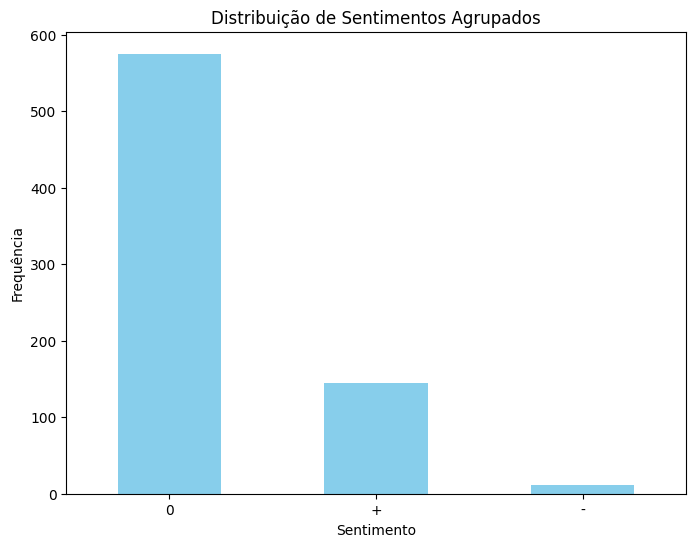

In [99]:
plt.figure(figsize=(8, 6))
distribuicao_sentimentos.plot(kind='bar', color='skyblue')
plt.title('Distribuição de Sentimentos Agrupados')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()

In [100]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.9, 0.1], flip_y=0, random_state=1)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [103]:
print(f'Classes antes do SMOTE: {dict(zip(*np.unique(y_train, return_counts=True)))}')
print(f'Classes após o SMOTE: {dict(zip(*np.unique(y_resampled, return_counts=True)))}')

Classes antes do SMOTE: {0: 711, 1: 89}
Classes após o SMOTE: {0: 711, 1: 711}


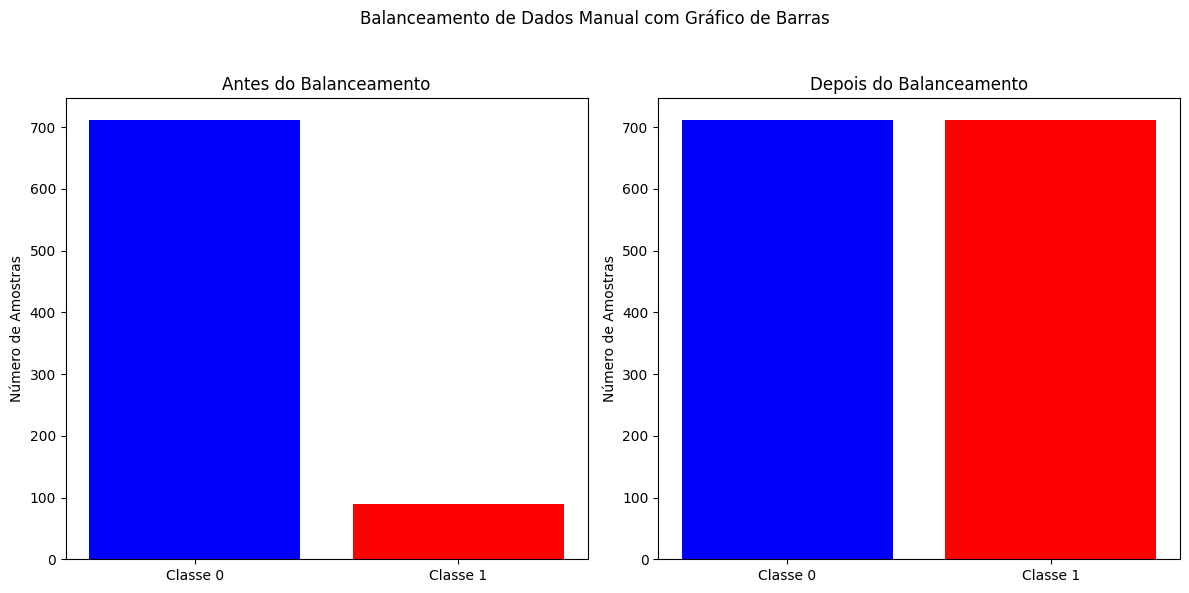

In [104]:
# Contando as ocorrências de cada classe antes e depois do balanceamento
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)

# Plotando os dados antes e depois do balanceamento em um gráfico de barras
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Antes do balanceamento
ax[0].bar(unique_classes_train, counts_train, color=['blue', 'red'])
ax[0].set_title("Antes do Balanceamento")
ax[0].set_xticks(unique_classes_train)
ax[0].set_xticklabels(['Classe 0', 'Classe 1'])
ax[0].set_ylabel("Número de Amostras")

# Depois do balanceamento
ax[1].bar(unique_classes_resampled, counts_resampled, color=['blue', 'red'])
ax[1].set_title("Depois do Balanceamento")
ax[1].set_xticks(unique_classes_resampled)
ax[1].set_xticklabels(['Classe 0', 'Classe 1'])
ax[1].set_ylabel("Número de Amostras")

plt.suptitle("Balanceamento de Dados Manual com Gráfico de Barras")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# **Extração de características com TF-IDF**

***Modelos para Dados Rasos:***

---

    'Logistic Regression',
    'SVM',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'AdaBoost',
    "KNN",
    "Naive Bayes",
    "Extra Trees",
    "XGBoost"

In [105]:
X = data['Text']
y = data['Sentimento_Agrupado']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicando o TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Convertendo para array denso para modelos que requerem isso
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Codificando os rótulos
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
# Definindo os modelos

modelos = {
    'Regressão Logística': LogisticRegression(max_iter=200),
    'SVM': SVC(probability=True),
    'Arvore de Decisão': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": GaussianNB(),
    "Extra Trees": ExtraTreesClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


In [106]:
# Variáveis para armazenar os melhores resultados
melhor_modelo = None
melhor_acuracia = 0
melhor_kappa = 0

In [107]:
# Treinando os modelos, avaliando a performance e calculando as matrizes de confusão
for nome, modelo in modelos.items():
    if nome == "Naive Bayes":
        # Naive Bayes requer entrada densa
        X_train_dense = X_train_tfidf.toarray()
        X_test_dense = X_test_tfidf.toarray()
        modelo.fit(X_train_dense, y_train_encoded)
        y_pred = modelo.predict(X_test_dense)
    else:
        modelo.fit(X_train_tfidf, y_train_encoded)
        y_pred = modelo.predict(X_test_tfidf)

    print(f"{nome}: Acurácia = {score:.2f}")

Regressão Logística: Acurácia = 0.50
SVM: Acurácia = 0.50
Arvore de Decisão: Acurácia = 0.50
Random Forest: Acurácia = 0.50
Gradient Boosting: Acurácia = 0.50
AdaBoost: Acurácia = 0.50
KNN: Acurácia = 0.50
Naive Bayes: Acurácia = 0.50


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Extra Trees: Acurácia = 0.50


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: Acurácia = 0.50


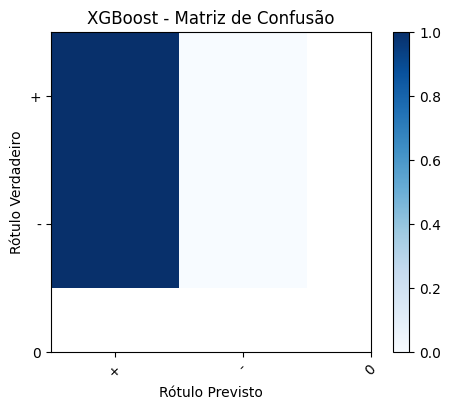

Melhor Modelo:
O melhor modelo foi: XGBoost
Acurácia = 0.50
Cohen Kappa Score = 0.00


In [108]:
    # Plotando a Matriz de Confusão
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{nome} - Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')
    plt.show()
  # Atualizando o melhor modelo
    if acuracia > melhor_acuracia:
        melhor_acuracia = acuracia
        melhor_kappa = kappa
        melhor_modelo = nome

# Resumo do melhor modelo
print("Melhor Modelo:")
print(f"O melhor modelo foi: {melhor_modelo}")
print(f"Acurácia = {melhor_acuracia:.2f}")
print(f"Cohen Kappa Score = {melhor_kappa:.2f}")
